In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
# Load dataset (replace with actual data)
df = pd.read_csv('german_credit_train.csv')

In [109]:
def create_features(df):

    df_fe = df.copy()

    # Binary features
    df_fe['is_high_installment'] = (df_fe['InstallmentPercent'] >= 4).astype(int)
    df_fe['is_young'] = (df_fe['Age'] < 40).astype(int)
    df_fe['is_long_loan'] = (df_fe['LoanDuration'] >= 30).astype(int)
    df_fe['is_large_loan'] = (df_fe['LoanAmount'] >= 5000).astype(int)
    df_fe['is_long_residence'] = (df_fe['CurrentResidenceDuration'] >= 4).astype(int)
    df_fe['no_checking'] = (df_fe['CheckingStatus'] == 'no_checking').astype(int)
    df_fe['bad_credit'] = df_fe['CreditHistory'].isin([
        'outstanding_credit', 'prior_payments_delayed'
    ]).astype(int)

    df_fe['risky_purpose'] = df_fe['LoanPurpose'].isin([
        'appliances', 'business', 'education', 'other', 'ratio_tv', 'repairs'
    ]).astype(int)

    df_fe['long_employment'] = df_fe['EmploymentDuration'].isin([
        'greater_7', '4_to_7'
    ]).astype(int)

    df_fe['NoOtherLoan'] = (df_fe['OthersOnLoan'] == 'none').astype(int)
    df_fe['OwnsPropertyUnknown'] = (df_fe['OwnsProperty'] == 'unknown').astype(int)
    df_fe['HousingFree'] = (df_fe['Housing'] == 'free').astype(int)
    

    # Numerical features

    # Payment to income ratio
    df_fe['InstallmentRatio'] = (df_fe['InstallmentPercent'] / 100) * \
                                 (df_fe['LoanAmount'] / df_fe['LoanDuration'])
    
    # Loan amount to age ratio (higher values might indicate higher risk)
    df_fe['LoanAmountPerAge'] = df_fe['LoanAmount'] / df_fe['Age']

    # Credit utilization proxy (higher values indicate more existing credit relative to income)
    df_fe['CreditUtilization'] = df['ExistingCreditsCount'] * df['LoanAmount'] / (df['Age'] - 18)

    # Loan burden (installment relative to dependents - higher might be riskier)
    df_fe['LoanBurden'] = df['InstallmentPercent'] * (df['Dependents'] + 1)

    return df_fe

In [16]:

def analyze_collinearity(df, threshold=5):
    # Step 1: Encode categorical variables if needed
    df_numeric = df.select_dtypes(include=[np.number]).copy()

    # If there are still categorical bins (LoanDurationBin, etc.), encode them
    for col in df.columns:
        if df[col].dtype == 'category' or df[col].dtype == 'object':
            df_numeric[col] = LabelEncoder().fit_transform(df[col].astype(str))

    print(f"\nNumeric Columns used for VIF and Correlation:\n{list(df_numeric.columns)}")

    # Step 2: Plot Correlation Heatmap
    plt.figure(figsize=(14, 10))
    corr = df_numeric.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Step 3: Compute VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

    # print("\nVariance Inflation Factor (VIF) results:")
    # display(vif_data.sort_values('VIF', ascending=False))

    # Step 4: Optional - Drop high VIF features
    # high_vif = vif_data[vif_data['VIF'] > threshold]
    # print(f"\nFeatures with VIF higher than {threshold}:")
    # display(high_vif)

    return vif_data.sort_values('VIF', ascending=False)


In [110]:
target = "Risk"
X = df.drop(columns=[target])
X = create_features(X)
y = df[target]

# analyze_collinearity(X)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


def compute_costs(LoanAmount):
     return({'Risk_No Risk': 5.0 + .6 * LoanAmount, 'No Risk_No Risk': 1.0 - .05 * LoanAmount,
         'Risk_Risk': 1.0, 'No Risk_Risk': 1.0})
def custom_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
   '''
   A custom metric for the German credit dataset
   '''
   real_prop = {'Risk': .02, 'No Risk': .98}
   train_prop = {'Risk': 1/3, 'No Risk': 2/3}
   custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
   costs = compute_costs(solution['LoanAmount'])
   y_true = solution['Risk']
   y_pred = submission['Risk']
   loss = (y_true=='Risk') * custom_weight['Risk'] *\
               ((y_pred=='Risk') * costs['Risk_Risk'] + (y_pred=='No Risk') * costs['Risk_No Risk']) +\
            (y_true=='No Risk') * custom_weight['No Risk'] *\
               ((y_pred=='Risk') * costs['No Risk_Risk'] + (y_pred=='No Risk') * costs['No Risk_No Risk'])
   # return loss.mean()
   return -np.mean(loss)


# Custom scorer that needs access to X
def cost_scorer(estimator, X, y_true):
    # Make predictions
    y_pred = estimator.predict(X)

    # Reconstruct `solution` and `submission` DataFrames
    solution = pd.DataFrame({
        'Risk': ['Risk' if val == 1 else 'No Risk' for val in y_true],
        'LoanAmount': X['LoanAmount'].values  # X must be the raw DataFrame
    })

    submission = pd.DataFrame({
        'Risk': ['Risk' if val == 1 else 'No Risk' for val in y_pred]
    })

    return custom_score(solution, submission, row_id_column_name=None)

# scorer = make_scorer(cost_scorer, greater_is_better=True)


In [21]:
def compute_class_weights(y_data):
    weights = compute_class_weight('balanced', classes=np.unique(y_data), y=y_data)
    class_weights = {0: weights[0], 1: weights[1]}
    sample_weights = [class_weights[label] for label in y_data]
    return sample_weights


In [111]:
numerical_cols = [
    'LoanDuration',
    'LoanAmount',
    'InstallmentPercent',
    'CurrentResidenceDuration',
    'Age',
    'ExistingCreditsCount',
    'InstallmentRatio',
    'LoanAmountPerAge',
    'CreditUtilization',
    'LoanBurden',
]

categorical_cols = [
    'CheckingStatus',
    'CreditHistory',
    'LoanPurpose',
    'ExistingSavings',
    'EmploymentDuration',
    'Sex',
    'OthersOnLoan',
    'OwnsProperty',
    'InstallmentPlans',
    'Housing',
    'Job',
    'Dependents',
    'Telephone',
    'ForeignWorker',]

binary_cols = [
    'is_high_installment',
    'is_young',
    'is_long_loan',
    'is_large_loan',
    'is_long_residence',
    'no_checking',
    'bad_credit',
    'long_employment',
    'risky_purpose',
    'NoOtherLoan',
    'OwnsPropertyUnknown',
    'HousingFree',
]


### Logistic Pipeline

In [139]:
# Identify categorical and numerical columns
cat_cols = categorical_cols
num_cols = numerical_cols

# Preprocessing for numerical data
num_transformer = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
cat_transformer = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ('binary', 'passthrough', binary_cols)
])

# Choose model type (classification or regression)
lr_model = LogisticRegression(
    penalty='l1',
    solver='saga',   # Needed for L1
    max_iter=5000,
    random_state=42
)

# Create full pipeline
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lr_model)
])

In [137]:
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

sample_weights = compute_class_weights(y_train)

In [140]:
param_grid_lr = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1.0],
    'model__max_iter': [1000, 3000, 5000],
}

search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=10,
    scoring=cost_scorer,
    n_jobs=-1
)

search_lr.fit(X_train, y_train, 
              model__sample_weight=sample_weights)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LoanDuration',
                                                                          'LoanAmount',
                                                                          'InstallmentPercent',
                                                                          'CurrentResidenceDuration',
                                                                          'Age',
                                                                          'ExistingCreditsCount',
                                                                          'InstallmentRatio',
                                                                          'LoanAmountPerAge',
                                                                          'CreditUtilization',
                                                                          'LoanBurden']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                          'is_long_residence',
                                                                          'no_checking',
                                                                          'bad_credit',
                                                                          'long_employment',
                                                                          'risky_purpose',
                                                                          'NoOtherLoan',
                                                                          'OwnsPropertyUnknown',
                                                                          'HousingFree'])])),
                                       ('model',
                                        LogisticRegression(max_iter=5000,
                                                           penalty='l1',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'model__max_iter': [1000, 3000, 5000]},
             scoring=<function cost_scorer at 0x16e77bb00>)

In [141]:
# Evaluate model
y_pred = search_lr.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {score:.4f}")

# Best parameters
print("Best parameters:", search_lr.best_params_)


# Compute actual score
actual_score = cost_scorer(search_lr.best_estimator_, X_test, y_test)
print(f"Kaggle Score (negative loss): {-actual_score:.4f}")

Accuracy: 0.7500
Best parameters: {'model__C': 1.0, 'model__max_iter': 1000}
Kaggle Score (negative loss): -60.3311


In [ ]:
best_pipeline = search_lr.best_estimator_
best_model = best_pipeline.named_steps['model']
preprocessor = best_pipeline.named_steps['preprocessor']

# ---- Step 1: Get feature names after preprocessing ----

# 1. Numerical columns (transformed)
num_features = preprocessor.transformers_[0][2]

# 2. Categorical columns (OneHotEncoded → expanded)
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
cat_original = preprocessor.transformers_[1][2]
cat_features = ohe.get_feature_names_out(cat_original)

# 3. Binary columns (unchanged)
bin_features = preprocessor.transformers_[2][2]

all_feature_names = list(num_features) + list(cat_features) + list(bin_features)

In [143]:
feature_map = {}

# Numerical
for col in num_features:
    feature_map[col] = col

# Categorical
for ohe_feat in cat_features:
    for col in cat_cols:
        if ohe_feat.startswith(col + "_"):
            feature_map[ohe_feat] = col
            break

# Binary
for col in bin_features:
    feature_map[col] = col


In [164]:
df_coef = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': best_model.coef_[0],
}).sort_values(by='Coefficient', key=abs, ascending=False)
display(df_coef[:10])

,Feature,Coefficient
16,CreditHistory_no_credits,-1.763930
46,OwnsProperty_real_estate,-1.321545
39,EmploymentDuration_unemployed,-0.842124
12,CheckingStatus_less_0,-0.732972
34,ExistingSavings_unknown,-0.719738
72,long_employment,0.699039
2,InstallmentPercent,-0.696947
49,InstallmentPlans_bank,-0.664438
38,EmploymentDuration_less_1,-0.617645
41,Sex_male,-0.596116


In [165]:
top_processed_features = df_coef['Feature'][:10].to_list()
top_features = list(set(feature_map[f] for f in top_processed_features))

print(f"✅ Selected {len(top_features)} raw features: {top_features}")

✅ Selected 9 raw features: ['Sex', 'OwnsProperty', 'InstallmentPercent', 'long_employment', 'ExistingSavings', 'InstallmentPlans', 'EmploymentDuration', 'CreditHistory', 'CheckingStatus']



Numeric Columns used for VIF and Correlation:
['InstallmentPercent', 'long_employment', 'Sex', 'OwnsProperty', 'ExistingSavings', 'InstallmentPlans', 'EmploymentDuration', 'CreditHistory', 'CheckingStatus']


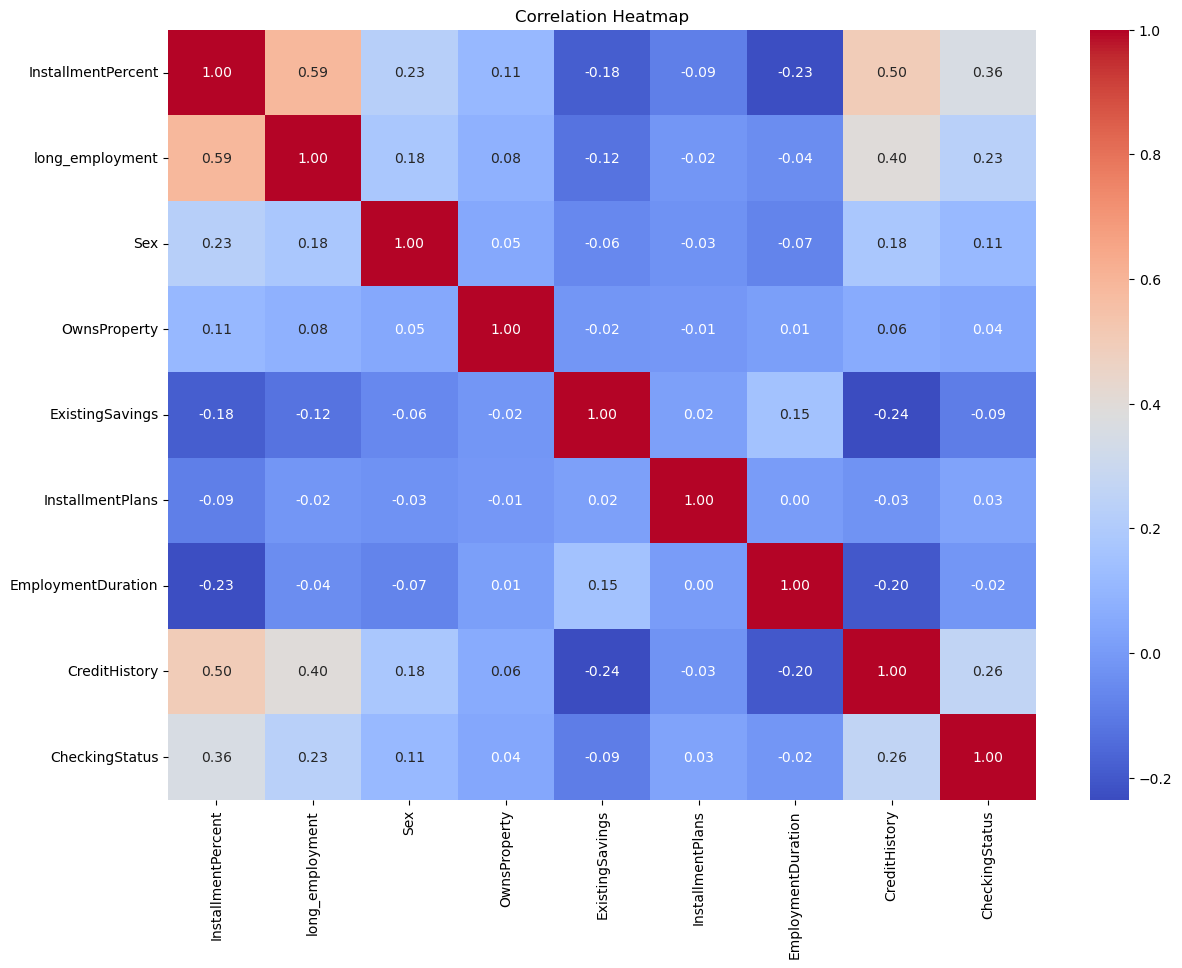

,feature,VIF
0,InstallmentPercent,11.024843
7,CreditHistory,4.416934
5,InstallmentPlans,4.074455
8,CheckingStatus,3.808765
1,long_employment,2.778777
4,ExistingSavings,2.749840
2,Sex,2.724799
3,OwnsProperty,2.491706
6,EmploymentDuration,2.250399


In [166]:
analyze_collinearity(X[top_features])

In [167]:
cat_cols_select = [col for col in top_features if col in categorical_cols]
num_cols_select = [col for col in top_features if col in numerical_cols]
bin_cols_select = [col for col in top_features if col in binary_cols]

# Combine preprocessors in a column transformer
preprocessor_select = ColumnTransformer([
    ('num', num_transformer, num_cols_select),
    ('cat', cat_transformer, cat_cols_select),
    ('binary', 'passthrough', bin_cols_select)
])

# Choose model type (classification or regression)
model = LogisticRegression(
    penalty='l2',
    # solver='saga',   # Needed for L1
    # max_iter=5000,
    random_state=42
)

# Create full pipeline
pipeline_select = Pipeline([
    ('preprocessor', preprocessor_select),
    ('model', model)
])


In [168]:
param_grid2 = {
    'model__C': [0.001, 0.005, 0.01, 0.05],
    'model__max_iter': [1000, 3000, 5000],
}

search_select = GridSearchCV(
    pipeline_select,
    param_grid2,
    cv=10,
    scoring=cost_scorer,
    n_jobs=-1
)

search_select.fit(X_train, y_train, 
              model__sample_weight=sample_weights)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['InstallmentPercent']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'OwnsProperty',
                                                                          'ExistingSavings',
                                                                          'InstallmentPlans',
                                                                          'EmploymentDuration',
                                                                          'CreditHistory',
                                                                          'CheckingStatus']),
                                                                        ('binary',
                                                                         'passthrough',
                                                                         ['long_employment'])])),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.005, 0.01, 0.05],
                         'model__max_iter': [1000, 3000, 5000]},
             scoring=<function cost_scorer at 0x16e77bb00>)

In [169]:
# Evaluate model
y_pred_select = search_select.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred_select)
print(f"Accuracy: {score:.4f}")

# Best parameters
print("Best parameters:", search_select.best_params_)


# Compute actual score
actual_score = cost_scorer(search_select.best_estimator_, X_test, y_test)
print(f"Kaggle Score (negative loss): {-actual_score:.4f}")

Accuracy: 0.7450
Best parameters: {'model__C': 0.01, 'model__max_iter': 1000}
Kaggle Score (negative loss): -55.5014


### LDA Pipeline

In [159]:
# Choose model type (classification or regression)
lda_model = LinearDiscriminantAnalysis()

# Create full pipeline
pipeline_lda = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lda_model)
])

In [160]:
param_grid_lda = {
    'model__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
    'model__solver': ['lsqr', 'eigen']  # Only supports shrinkage with these solvers
}

search_lda = GridSearchCV(
    pipeline_lda,
    param_grid_lda,
    cv=10,
    scoring=cost_scorer,
    n_jobs=-1
)

search_lda.fit(X_train, y_train)

/Users/chwang/anaconda3/envs/mlenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chwang/anaconda3/envs/mlenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chwang/anaconda3/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chwang/anaconda3/envs/mlenv/lib/python3.1

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LoanDuration',
                                                                          'LoanAmount',
                                                                          'InstallmentPercent',
                                                                          'CurrentResidenceDuration',
                                                                          'Age',
                                                                          'ExistingCreditsCount',
                                                                          'InstallmentRatio',
                                                                          'LoanAmountPerAge',
                                                                          'CreditUtilization',
                                                                          'LoanBurden']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('...
                                                                          'is_long_loan',
                                                                          'is_large_loan',
                                                                          'is_long_residence',
                                                                          'no_checking',
                                                                          'bad_credit',
                                                                          'long_employment',
                                                                          'risky_purpose',
                                                                          'NoOtherLoan',
                                                                          'OwnsPropertyUnknown',
                                                                          'HousingFree'])])),
                                       ('model',
                                        LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'model__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
                         'model__solver': ['lsqr', 'eigen']},
             scoring=<function cost_scorer at 0x16e77bb00>)

In [161]:
# Evaluate model
y_pred = search_lda.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {score:.4f}")

# Best parameters
print("Best parameters:", search_lda.best_params_)


# Compute actual score
actual_score = cost_scorer(search_lda.best_estimator_, X_test, y_test)
print(f"Kaggle Score (negative loss): {-actual_score:.4f}")

Accuracy: 0.7887
Best parameters: {'model__shrinkage': None, 'model__solver': 'lsqr'}
Kaggle Score (negative loss): -81.3475


In [ ]:
coef = search_lda.best_estimator_.named_steps['model'].coef_

array([[ 0.45024583,  0.00383248, -1.12561099,  0.39717564,  0.13200119,
         0.45895504,  0.05162475, -0.17183149,  0.04811561,  0.85055811,
        -0.19225673,  0.30857938, -0.55351436,  0.43719171,  0.0090068 ,
         0.11189596, -0.37282708,  0.33167978, -0.07975546,  0.03115348,
        -0.49161144,  0.18286555,  0.05865294,  0.20836195,  0.1965985 ,
         0.04169581,  0.16094069,  0.21707116, -0.45802263, -0.147706  ,
         0.20404144,  0.13172495, -0.05371574,  0.60439217, -0.88644282,
         0.11067867, -0.05407222,  0.89110358, -0.54531856, -0.40239147,
         0.39473718, -0.39473718,  0.2747645 ,  0.2009517 , -0.4757162 ,
         0.31648626, -0.76341287, -0.12368795,  0.57061457, -0.34236184,
         0.3948561 , -0.05249425, -0.09311775, -0.17434159,  0.26745934,
         0.07156104,  0.12025563,  0.10628144, -0.29809812,  0.40015295,
        -0.40015295, -0.09693056,  0.09693056,  0.0283438 , -0.0283438 ,
        -0.30290565,  0.34619899,  0.18976921,  0.0

### Final Submission

In [170]:
test_df = pd.read_csv('german_credit_test.csv')
X_test_final = test_df.drop(columns=[target], errors='ignore') # Drop target column if it exists
X_test_final = create_features(X_test_final)  # Create features

# Clean best parameters (remove 'model__' prefix)
best_params_clean = {k.replace('model__', ''): v for k, v in search_lda.best_params_.items()}

# Generate predictions
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearDiscriminantAnalysis(
        **best_params_clean,  # Uses best params found in GridSearch
    ))
])

final_model.fit(X, y)
y_pred_final = final_model.predict(X_test_final)

predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'Risk': ['Risk' if p == 1 else 'No Risk' for p in y_pred_final]}
                              )
predictions_df.to_csv('german_credit_test_predictions.csv', index=False)